## **Loan Approval ML Model**

In [39]:
!pip install keras-tuner
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers
import keras_tuner as kt
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler

In [40]:
test_data = pd.read_csv('loan_data_testing.csv')
train_data = pd.read_csv('loan_data_training.csv')

In [41]:
train_data.head(10)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
5,5,27,45000,RENT,2.0,VENTURE,A,9000,8.94,0.20,N,5,0
6,6,25,45000,MORTGAGE,9.0,EDUCATION,A,12000,6.54,0.27,N,3,0
7,7,21,20000,RENT,0.0,PERSONAL,C,2500,13.49,0.13,Y,3,0
8,8,37,69600,RENT,11.0,EDUCATION,D,5000,14.84,0.07,Y,11,0
9,9,35,110000,MORTGAGE,0.0,DEBTCONSOLIDATION,C,15000,12.98,0.14,Y,6,0


In [42]:
test_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [43]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [44]:
train_data.shape

(58645, 13)

In [45]:
train_data.duplicated().sum()

0

In [46]:
categorical_cols=train_data.select_dtypes(include='object').columns
numerical_cols=train_data.select_dtypes(exclude='object').columns
print(categorical_cols)
print(numerical_cols)

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')
Index(['id', 'person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'loan_status'],
      dtype='object')


In [47]:
numerical_cols=numerical_cols.drop(['id','loan_status'])

In [48]:
for col in categorical_cols:
    print(col," -> ",train_data[col].unique())

person_home_ownership  ->  ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent  ->  ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
loan_grade  ->  ['B' 'C' 'A' 'D' 'E' 'F' 'G']
cb_person_default_on_file  ->  ['N' 'Y']


In [49]:
for col in categorical_cols:
    print(col," -> ",test_data[col].unique())

person_home_ownership  ->  ['RENT' 'MORTGAGE' 'OWN' 'OTHER']
loan_intent  ->  ['HOMEIMPROVEMENT' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION' 'EDUCATION'
 'MEDICAL']
loan_grade  ->  ['F' 'C' 'E' 'A' 'D' 'B' 'G']
cb_person_default_on_file  ->  ['N' 'Y']


In [50]:
onehot=['person_home_ownership','loan_intent','cb_person_default_on_file']
ordinal=['loan_grade']
ordinal_cat=['A','B','C','D','E','F','G']
transformer=ColumnTransformer([('onehot',OneHotEncoder(), onehot),
                               ('ordinal',OrdinalEncoder(categories=[ordinal_cat]),ordinal),
                              ('minmax',MinMaxScaler(),numerical_cols)],
                             remainder='passthrough',n_jobs=-1)
train_=transformer.fit_transform(train_data)

In [51]:
onehot_feature_names = transformer.named_transformers_['onehot'].get_feature_names_out(onehot)
ordinal_feature_names = ordinal
numeric_feature_names = numerical_cols
all_feature_names = list(onehot_feature_names) + list(ordinal_feature_names) + list(numeric_feature_names) + list(['id','loan_status'])
train_df = pd.DataFrame(train_, columns=all_feature_names)

In [52]:
test_=transformer.fit_transform(test_data)

In [53]:
all_feature_names = list(onehot_feature_names) + list(ordinal_feature_names) + list(numeric_feature_names) + list(['id'])
test_df = pd.DataFrame(test_, columns=all_feature_names)

In [54]:
X=train_df.iloc[:,0:20]
y=train_df.iloc[:,21:]

In [55]:
model=Sequential()
model.add(layers.Dense(64,activation='relu',name="layer1",input_dim=X.shape[1]))
model.add(layers.Dense(32,activation='relu',name="layer2"))
model.add(layers.Dense(16,activation='relu',name="layer3"))
model.add(layers.Dense(8,activation='relu',name="layer4"))
model.add(layers.Dense(1,activation='sigmoid',name="layer5"))

In [56]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                       │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (Dense)                       │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer3 (Dense)                       │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer4 (Dense)                       │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer5 (Dense)                       │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
optimizer=keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [58]:
finvib=model.fit(X,y,batch_size=200,epochs=10,validation_split=0.25)

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8739 - loss: 0.3115 - val_accuracy: 0.9276 - val_loss: 0.2344
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9239 - loss: 0.2281 - val_accuracy: 0.9297 - val_loss: 0.2082
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9319 - loss: 0.2087 - val_accuracy: 0.9304 - val_loss: 0.2051
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9304 - loss: 0.2098 - val_accuracy: 0.9355 - val_loss: 0.1931
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9373 - loss: 0.1949 - val_accuracy: 0.9422 - val_loss: 0.1933
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9371 - loss: 0.1949 - val_accuracy: 0.9393 - val_loss: 0.1872
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9387 - loss: 0.1930 - val_accuracy: 0.9396 - val_loss: 0.1888
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9386 - loss: 0.1915 - val_accuracy: 

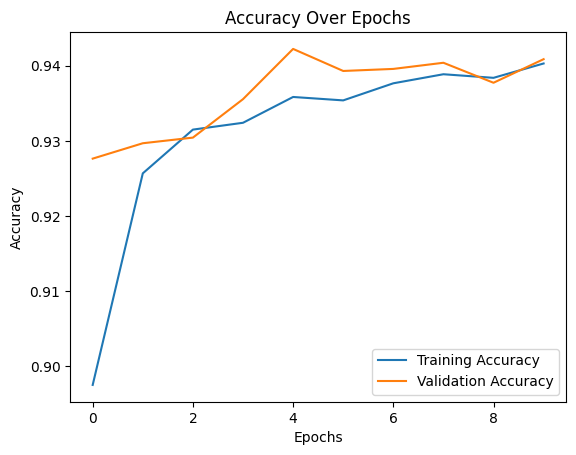

In [59]:
# Plot training and validation accuracy
plt.plot(finvib.history['accuracy'], label='Training Accuracy')
plt.plot(finvib.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()